# Search Widget AB Test Report

**Megan Neisler, Data Scientist, Wikimedia Foundation**

**1 July 2021**

[TASK](https://phabricator.wikimedia.org/T275200) | [CODEBASE](https://github.com/wikimedia-research/Desktop-Improvements-Search-Widget-Analysis-2021)

# Table of Contents

1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Search Sessions Initiated](#Search-Sessions-Initiated)
4. [Other Interesting Search Trends](#Other-Interesting-Search-Trends)

# Introduction

The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team) is working on researching and building out improvements to the desktop experience to make Wikimedia wikis more welcoming and to increase the utility amongst readers while maintaining utility for existing editors.

As part of this effort, the Web team deployed changes focused on improving the search experience. This included (1) moving the search bar to a more prominent location  and (2) adding images and other contextual information to the search widget to improve the scannability of the search results. An AB test was performed on each of these changes on the early adopter wikis.

This report details the analysis and results for the Search Widget AB test. The new search widget (as shown in the screenshot below) includes an image for the page and description for the page (if available) that appears in the search results as a user starts typing. You can find more information on this change and other feature deployments on the [desktop improvement project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements).

![](Figures/new_search_widget_screenshot.png)
Screenshot by Alex Hollender available on [Wikimedia Commons](https://commons.wikimedia.org/wiki/Main_Page), licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en).

The team ran an AB test of the new location from 11 March 2021 through 30 March 2021[^1]to assess the efficacy of this feature. The test included all logged-in users on the [early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)). In the test, 50% of logged-in users saw the updated search widget, while the other 50% saw the previous search widget witout the added images and text. Both of these groups saw the search bar in the new header location.

[^1]: While the AB test was run through 30 March 2021, the last week of data was incomplete due to a regression identified in [T274869](https://phabricator.wikimedia.org/T274869#6963147) and was excluded.


# Purpose

The primary goal of the AB Test was to test the hypothesis that the group with the new search widget will initiate more search sessions. The target was identified as 2.5% overall increase in search sessions initiated. We reviewed the average change in search sessions initiated across all early adopter wikis and reviewed any differences by each early adopter wiki and by user edit count. 

As part of this analysis, we were also interested in identifying any observed changes in search behavior before and after the change for logged-out users as well as any other interesting search trends.



# Methodology

The AB test was run on a per wiki basis and users included in the test were randomly assigned to either the control (old search widget) or treatment (new search widget) based on their user ID and received the same treatment the duration of the test. The test was deployed to all logged-in users viewing the vector desktop skin on one of the early adopter wikis. 

Data was collected in the [SearchSatisfaction](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/searchsatisfaction/current.yaml) event logging table.

See the following Phabricator tickets for further details regarding the instrumentation and implementation of the AB test:

  * AB test set-up [T261647](https://phabricator.wikimedia.org/T261647).
  * AB test deployment [T249297](https://phabricator.wikimedia.org/T249297)
  * Instrumentation details [T256100](https://phabricator.wikimedia.org/T256100)
  * Instrumentation QA [T274869](https://phabricator.wikimedia.org/T274869)


In [445]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [79]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); 
    library(lubridate); 
    library(scales);
    library(magrittr); 
    library(dplyr);
   # Tables:
    library(gt);
    library(gtsummary);
    library(knitr);
    library(broom)
   # Modeling 
    library(effsize);
    library(brms);
    library(tidybayes);
    library(infer)
})


In [14]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Search Sessions Initiated

A search session begins when a user starts typing in the search widget. We measured the number of unique search sessions initiated for each search widget type and early adopter wiki included in the AB Test. 

The analysis excludes search sessions with more than 50 searches in a session as these are likely from automated traffic. We also removed Venetian Wikipedia from this analysis as it only had 23 total search sessions included in the AB test and we are not able to accurately determine rates representative of the population.

In [226]:
# collect all search session initated from SearchSatisfaction for the relevant fields.
sessions_initiated_query <- 
"
SELECT
    MIN(TO_DATE(dt)) as session_start_date,
    event.searchSessionID as search_session,
    event.isAnon AS is_anonymous,
    event.extraParams AS search_type,
    event.skinVersion AS vector_version,
    event.inputLocation AS search_location,
    event.skin AS skin,
    wiki AS wiki,
    min(event.usereditbucket) AS edit_count,
    SUM(1) as num_searches
FROM event.searchSatisfaction 
    WHERE YEAR = 2021
    AND (MONTH >= 02 and MONTH <= 04)
    -- remove flagged bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
-- only autcomplete searches done using search widget 
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
-- only early adopter wikis
    AND wiki IN ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki' )
GROUP BY 
    event.searchSessionID,
    event.isAnon,
    event.extraParams,
    event.skinVersion,
    event.inputLocation,
    event.skin,
    wiki
"

In [ ]:
# search_sessions_initiated <-  wmfdata::query_hive(sessions_initiated_query)

In [228]:
# write_csv(search_sessions_initiated, file = 'Data/search_sessions_initiated_w_skinversion.csv')

In [36]:
search_sessions_initiated <- read_csv('Data/search_sessions_initiated_w_skinversion.csv')

In [40]:
search_sessions_initiated <- search_sessions_initiated %>%
    mutate(
    wiki = case_when( #clarfiy Wiki project names
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'),
        # format search type and edit count as factors and specify levels
        search_type = factor(
            search_type , 
            levels = c("NULL", "WVUI"),
            labels = c("old_search_widget", "new_search_widget")
        ),
        edit_count = factor(
            edit_count, 
            levels = c("0 edits", "1-4 edits", "5-99 edits", 
                       "100-999 edits", "1000+ edits")
        )
    )


In [42]:
#isolate to AB test users
search_sessions_initiated_abtest <- search_sessions_initiated %>%
    filter(
        vector_version ==  'latest',#AB done on latest version of vector with new location
        wiki != 'Venetian Wikipedia',
        skin == 'vector',
        search_location == 'header-moved',
        session_start_date > '2021-03-10' & # dates of complete AB test data
        session_start_date <'2021-03-17',
        is_anonymous == 'false', # only logged-in users included in test
        num_searches < 50) # remove sessions with over 50 sessions as these are an indicator of auto traffic
      

## Overall

In [43]:
# sessions initated overall by group
search_sessions_initiated_overall <- search_sessions_initiated_abtest %>%
    group_by(search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

search_sessions_initiated_overall

search_type,num_sessions
<fct>,<int>
old_search_widget,17901
new_search_widget,19675


In [44]:
# daily overall trends
search_sessions_initiated_byday <- search_sessions_initiated_abtest %>%
    group_by(session_start_date, search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 


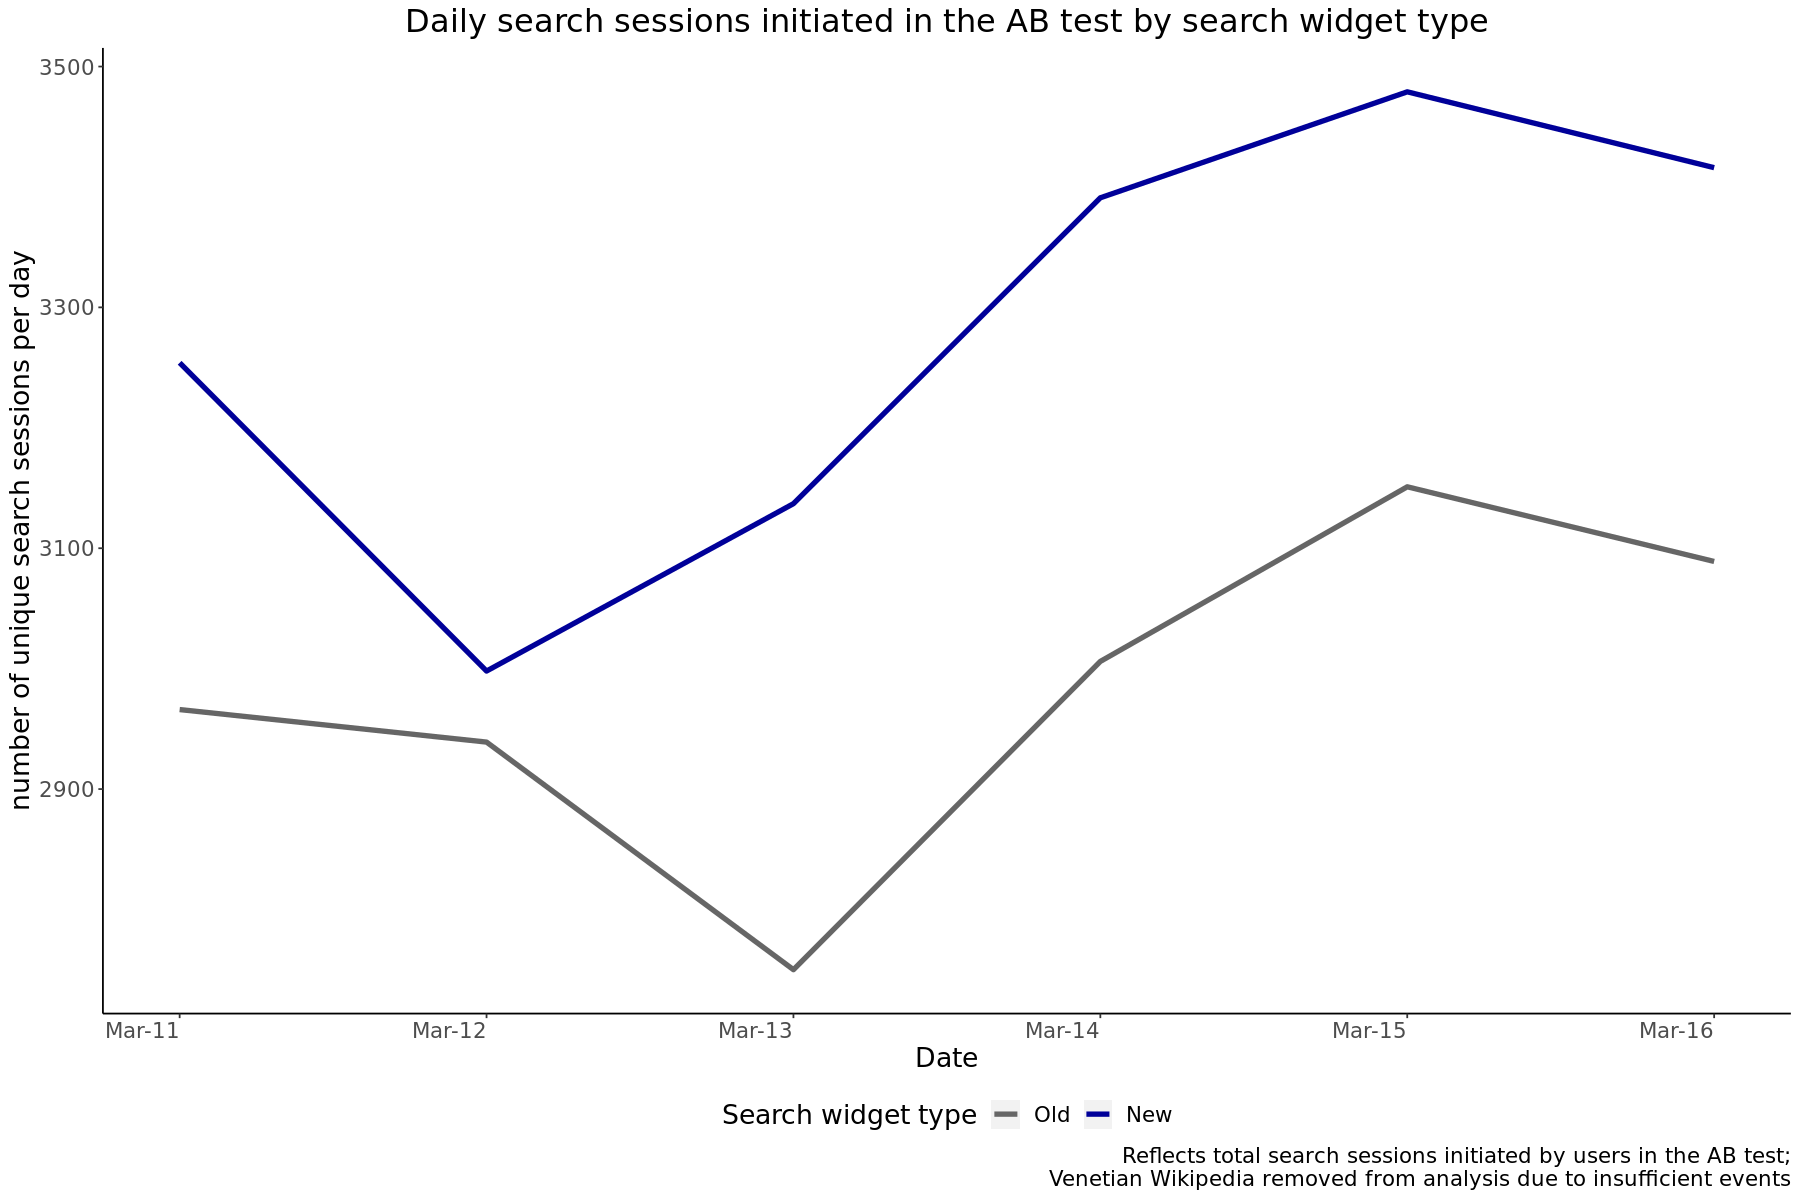

In [300]:
p <- search_sessions_initiated_byday %>%
    ggplot(aes(x=session_start_date, y = num_sessions, color = search_type)) +
    geom_line(size = 1.5) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 day", minor_breaks = NULL) +
    labs(y = "number of unique search sessions per day",
          x = "Date",
         title = "Daily search sessions initiated in the AB test by search widget type",
        caption = "Reflects total search sessions initiated by users in the AB test;
                        Venetian Wikipedia removed from analysis due to insufficient events")  +
    scale_color_manual(values= c("#666666", "#000099"), name = "Search widget type", labels = c("Old", "New"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_text(hjust=1),
        axis.line = element_line(colour = "black")) 

p


Across all early adopter wikis, there have consistently been more daily search sessions initiated with the new search widget (treatment) than with the old search widget (control). Overall, there was a 9.9% increase in search sessions initiated.

## Early Adopter Wikis

In [46]:
search_sessions_initiated_bywiki <- search_sessions_initiated_abtest %>%
    group_by(wiki, search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop')  


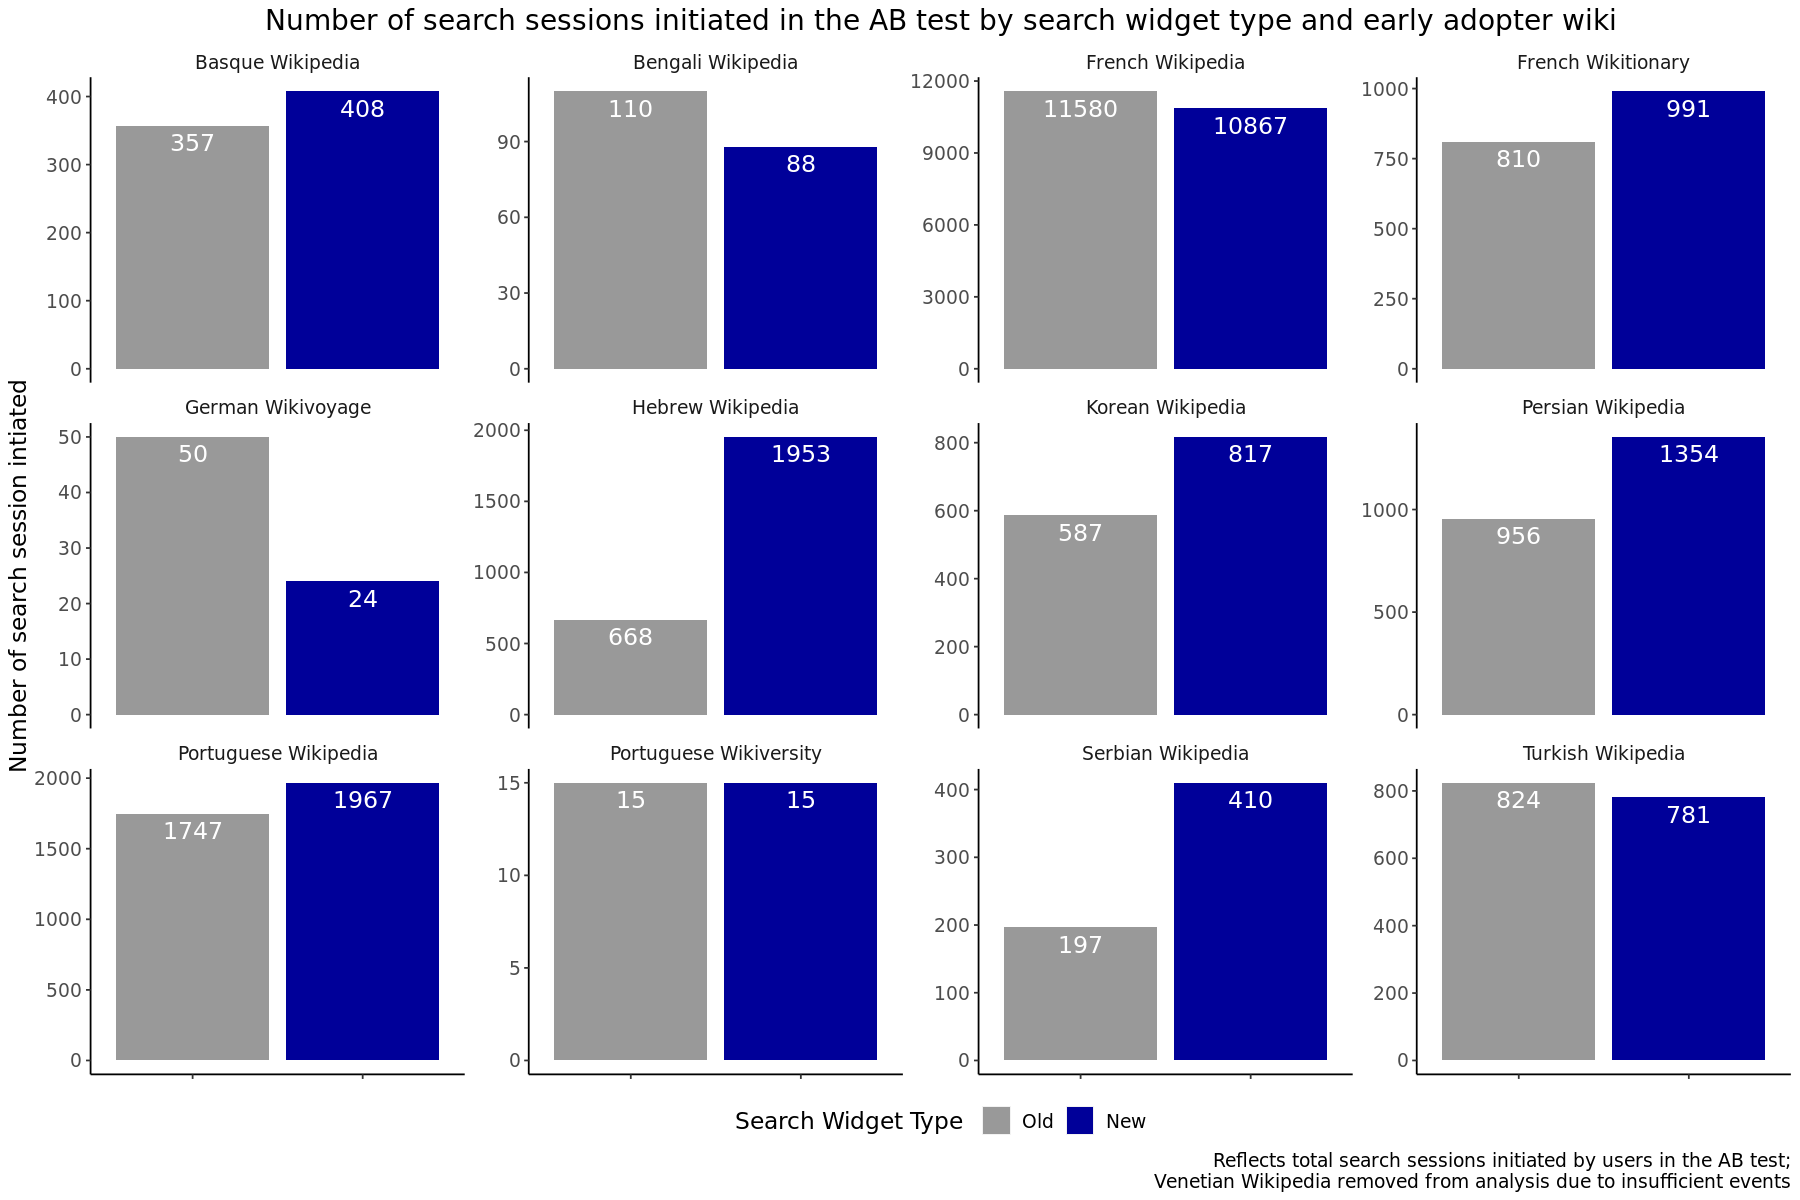

In [301]:
# Plot search sessions initiated by search widget type and wiki

p <- search_sessions_initiated_bywiki %>%
        ggplot(aes(x = search_type, y= num_sessions, fill = search_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "Number of search session intiated",
             title = "Number of search sessions initiated in the AB test by search widget type and early adopter wiki",
             caption = "Reflects total search sessions initiated by users in the AB test;
                        Venetian Wikipedia removed from analysis due to insufficient events") +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search Widget Type", labels = c("Old", "New"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

In [51]:
# determine percent change
search_sessions_initiated_bywiki_pct <- search_sessions_initiated_bywiki %>%
    spread(search_type, num_sessions) %>%
    mutate(pct_change = round((new_search_widget - old_search_widget)/old_search_widget * 100, 2)) 

In [53]:
search_sessions_initiated_bywiki_pct_tbl <- search_sessions_initiated_bywiki_pct %>%
    gt() %>%
    tab_header("Search sessions initiated in the AB test") %>%
    cols_label(wiki = "Wiki project",
               old_search_widget = "Old search widget", 
               new_search_widget = "New search widget",
               pct_change = "Percent Change") %>%
    tab_spanner("Number of search sessions", 2:3) %>%
      gtsave(
    "search_sessions_initiated.html", inline_css = TRUE)


IRdisplay::display_html(data = search_sessions_initiated_bywiki_pct_tbl, file = "search_sessions_initiated.html")


Number of search sessions


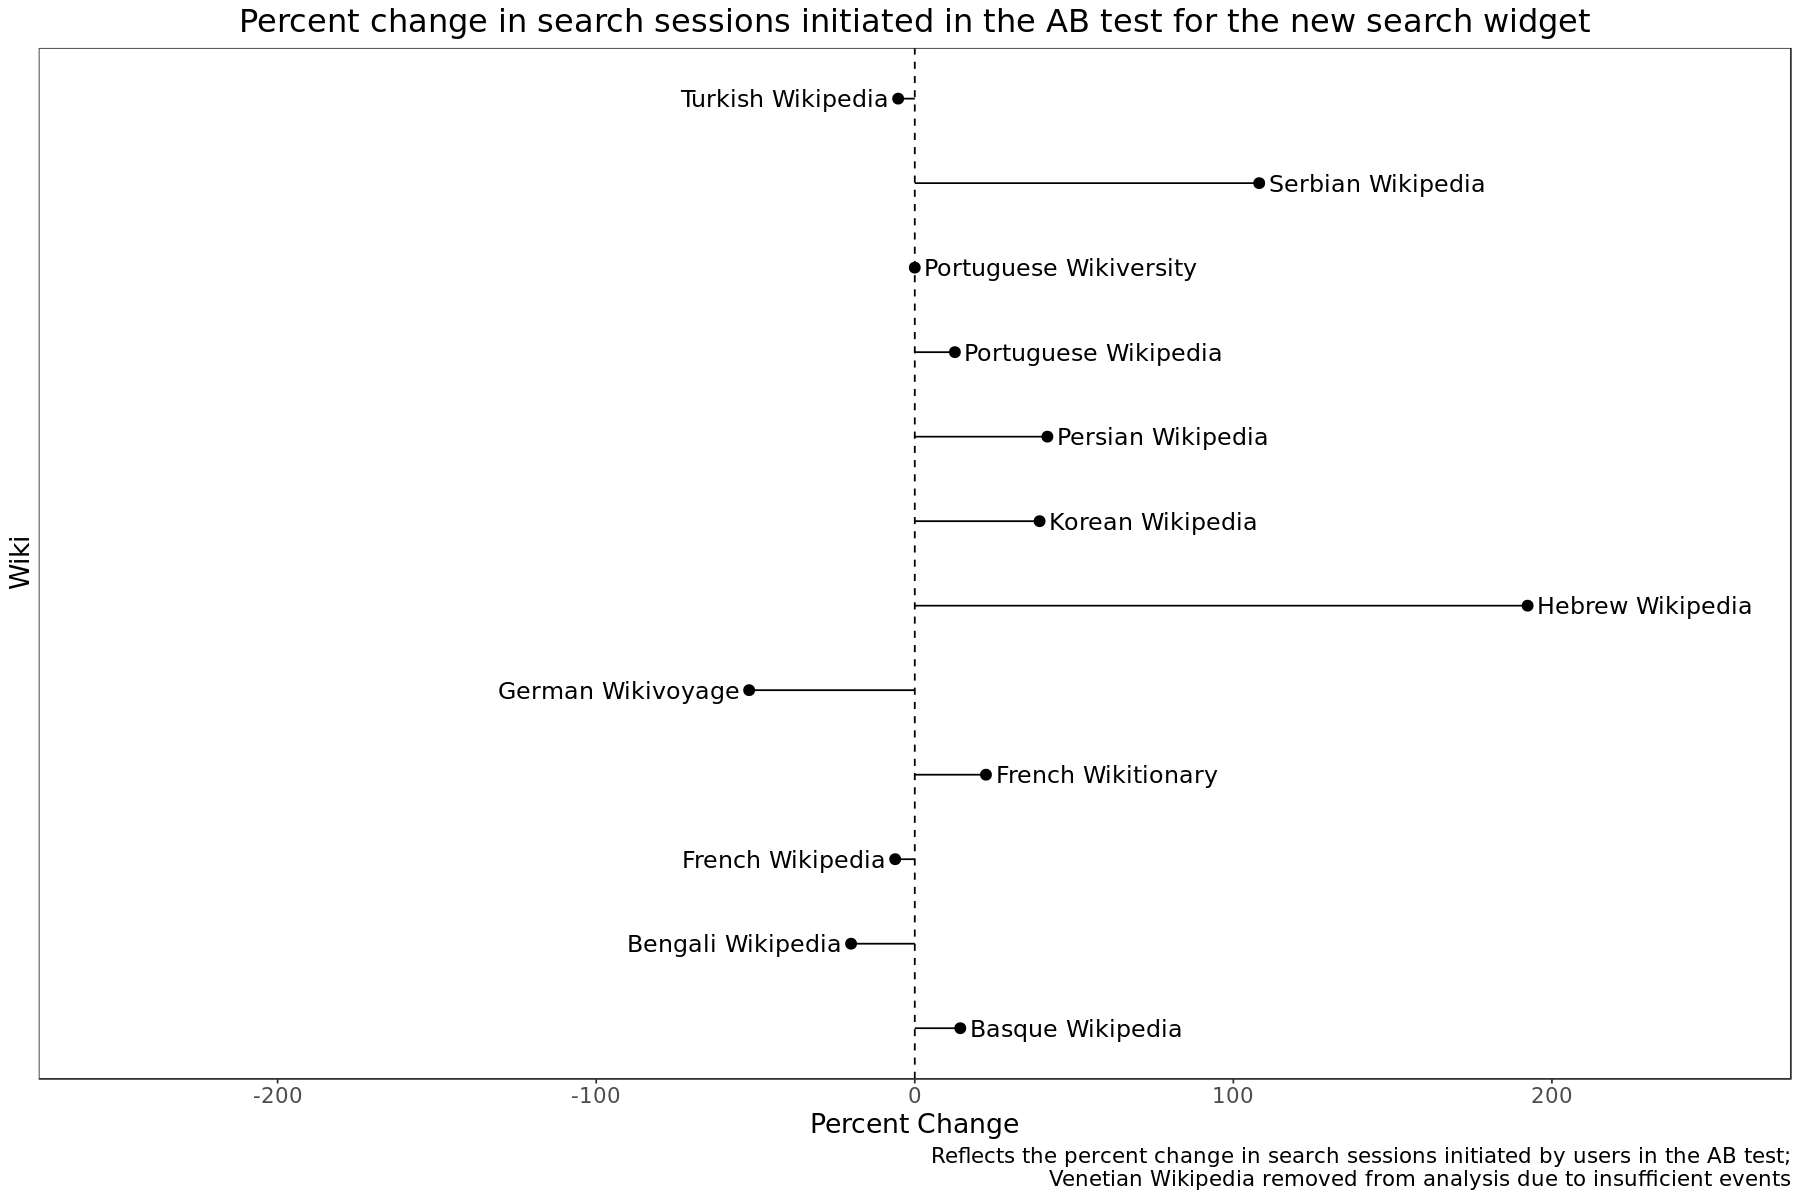

In [302]:
# chart percent change between old and new search widget

p <- search_sessions_initiated_bywiki_pct %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -3, 3),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5,
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-250, 250)) +
        labs (x = "Wiki",
            y = "Percent Change",
             title = "Percent change in search sessions initiated in the AB test for the new search widget", 
            caption = "Reflects the percent change in search sessions initiated by users in the AB test;
            Venetian Wikipedia removed from analysis due to insufficient events") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
p

There was an average 28.93%[^2] increase in search sessions initiated by users shown the new search widget on the early adopter wikis.

Results varied on a per wiki basis, with some observed increases and decreases in search sessions initiated between the two test groups. 

Some key observations:
* For 7 out of the 12 early adopter wikis, there was an increase in the number of search sessions initiated in the new search widget test group. 
* Most increases ranged from about 12% to 22% but search sessions initiated were more than double on Serbian and Hebrew Wikipedia.
* The highest decreases were seen on German WikiVoyage (-52%) and Bengali Wikipedia (-20%); however, both of these wikis had under 100 search sessions recorded for each search widget type during the AB test.
 
 
[^2]: Calculated by taking the average of the percent changes observed on each early adopter wiki.

## Modeling the impact

We used a paired [Welch two-sample t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) to determine if there is statistical difference in the average search sessions initiated between the two test groups.

A one-tailed test was used to test if the average number of sessions initiated with the new search widget are greater than the average number of sessions initiated with the old search widget. In this model, each wiki represents an observational unit.

In [85]:
tfit <- search_sessions_initiated_bywiki %>%
        t_test(formula = num_sessions ~ search_type,  
               paired = TRUE, 
               alternative = 'greater')
tfit

Warning message:
“The statistic is based on a difference or ratio; by default, for difference-based statistics, the explanatory variable is subtracted in the order "old_search_widget" - "new_search_widget", or divided in the order "old_search_widget" / "new_search_widget" for ratio-based statistics. To specify this order yourself, supply `order = c("old_search_widget", "new_search_widget")`.”


statistic,t_df,p_value,alternative,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
-1.134644,11,0.8596775,greater,-381.8201,Inf


In [86]:
cohen.d(num_sessions ~ search_type, data = search_sessions_initiated_bywiki, paired = TRUE)

Warning message in cohen.d.formula(num_sessions ~ search_type, data = search_sessions_initiated_bywiki, :
“Trying to compute paired samples Cohen's d using formula input. Results may be incorrect if cases do not appear in the same order for both levels of the grouping factor. Use the format 'value ~ treatment | Subject(id)' to specify a subject id variable.”



Cohen's d

d estimate: -0.04104081 (negligible)
95 percent confidence interval:
      lower       upper 
-0.11608573  0.03400411 


Results of the model indicate that we do not have sufficient evidence to confirm statistical difference between the number of search sessions initiated between the two groups, as indicated by a p-value higher than 0.05.
 
We also looked at the effect size, using the [Cohen's d](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) method, to determine the strength of the relationship between the search widget type and number of sessions initiated. Based on the data collected in the AB test, the difference between the two groups is negligible.
 
In summary, while we observed a 28.9% in the search sessions initiated, there is not sufficient evidence to definitively say that the new search widget led to the increase in observed search sessions initiated. Increasing the sample size by running the AB test on more wikis would potentially help, as each wiki is the observational unit in this experiment.


## Users Edit Count

We also took a look at the difference in search sessions initiated across the different user group experience levels (based on their cumulative edits) to determine if a user's experience level has any impact on the number of search sessions they initiate with the new search widget. 

In [87]:
search_sessions_initiated_byeditcount <- search_sessions_initiated_abtest %>%
    filter(edit_count != 'NA') %>% # one NA instance recorded by a logged-in user.
    group_by(edit_count, search_type) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

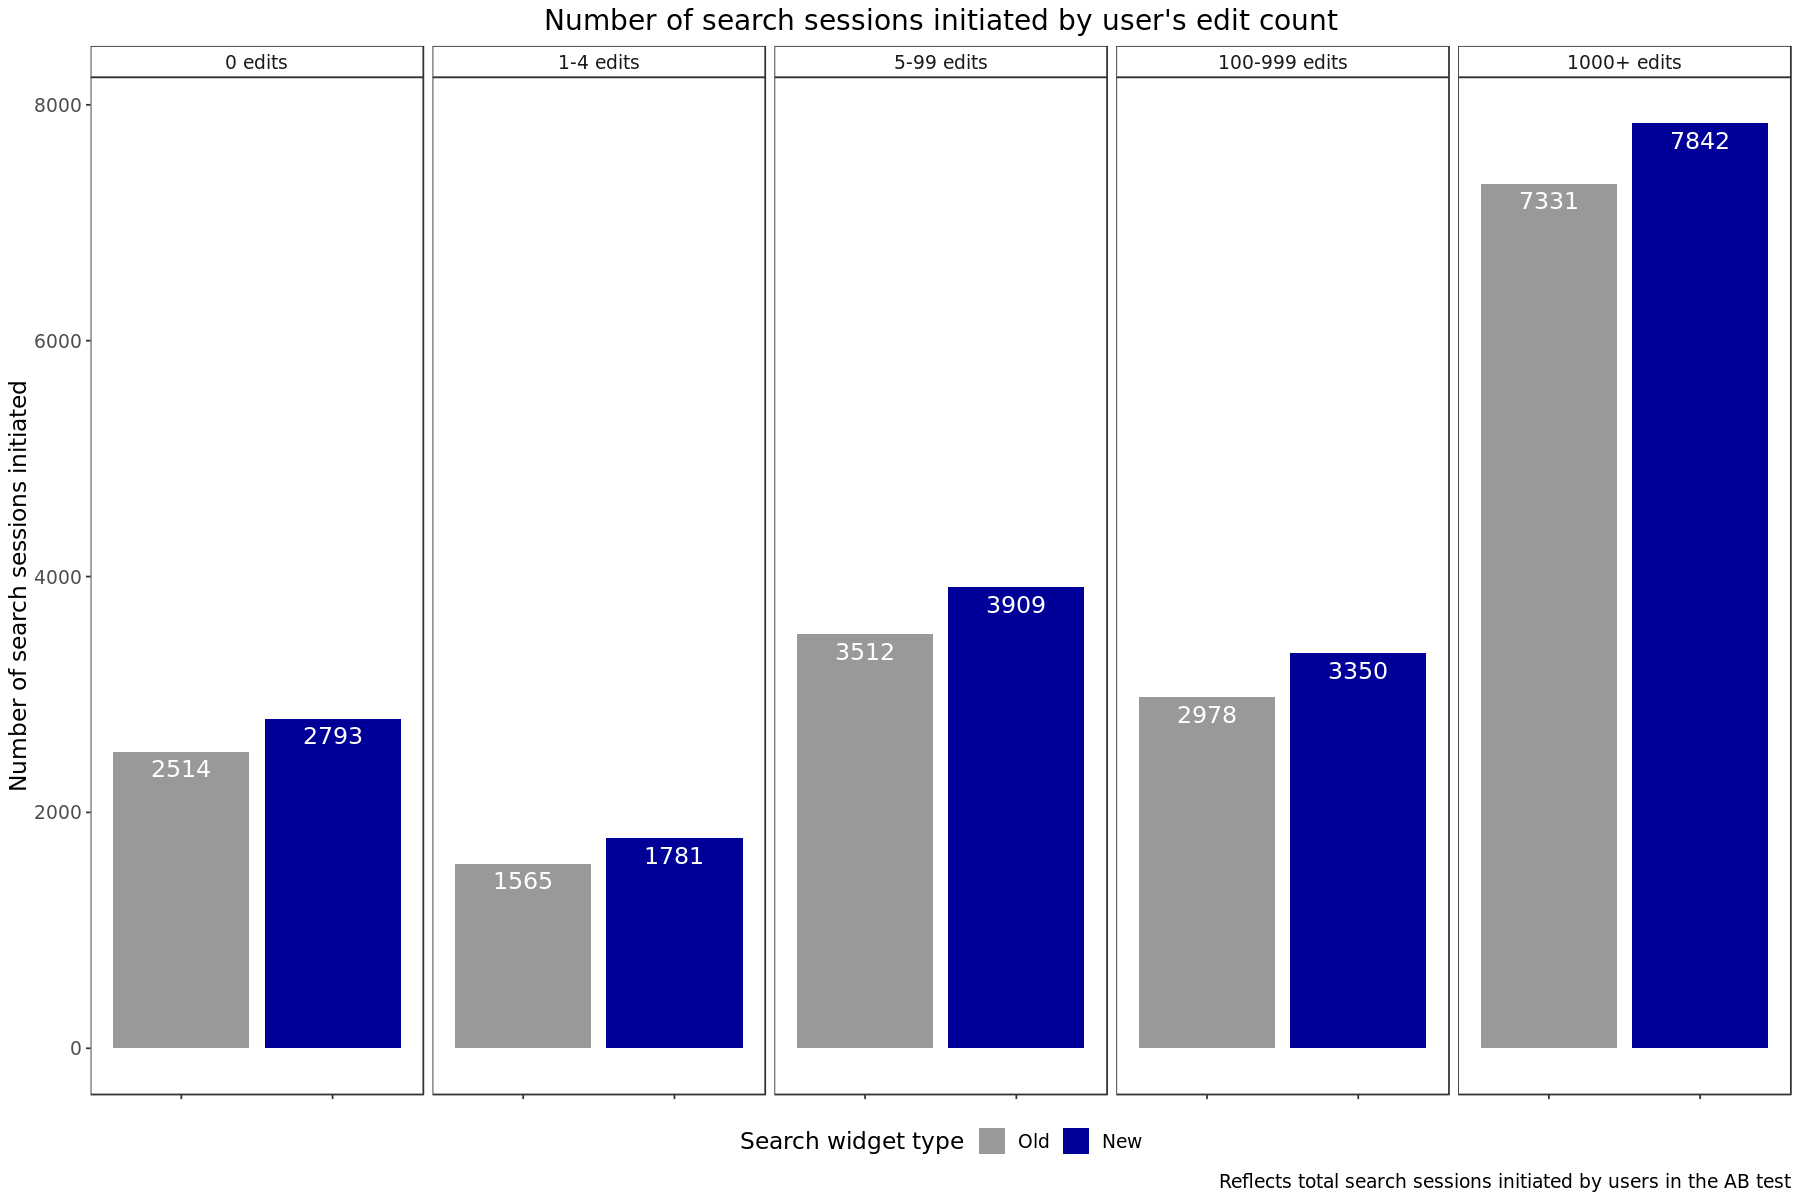

In [303]:
p <- search_sessions_initiated_byeditcount  %>%
        ggplot(aes(x=search_type, y= num_sessions, fill = search_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 5) +
        facet_grid( ~ edit_count, scale = "free_y") +
        labs (y = "Number of search sessions initiated",
              x = NULL,
             title = "Number of search sessions initiated by user's edit count",
             caption = "Reflects total search sessions initiated by users in the AB test")  +
        theme_bw() +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old", "New"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      
p


Search sessions initiated were higher for the new search widget across all five user experience level groups suggesting that a user's editing experience is not a significant factor in the number of search sessions they initiate with either search widget. 

## Logged Out Users Pre and Post Deployment Analysis

Logged-out users were not included in the AB test; however, we reviewed search sessions initiated before and after deployment of the new search widget to identify any changes in user behavior that might have resulted from the change. 

**Deployment Details**

The new search widget was deployed as default to all logged-out users of the early adopter wikis on 1 March 2021.

Prior to deployment of the new search widget, logged-out users on the early adopter wikis were shown different states of the vector skin and search location depending on when the wiki was included as an early adopter wiki.

The [second group of early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)) were shown the old search location on legacy vector prior to deployment. The [first group of early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)) were shown the new search location on the latest vector prior to deployment.

**Reviewed Timeline**

Data from 1 March 2021 through 10 March 2021 was incomplete due to a bug that resulted in a large portion of the new search widget sessions not being recorded. See [Gerrit Change](https://gerrit.wikimedia.org/r/c/mediawiki/extensions/WikimediaEvents/+/670459/). This data was excluded from the analysis. Instead, we reviewed one full week of data available prior to deployment (18 Feb 2021 to 24 Feb 2021) and one full week of data available post deployment (11 March 2021 to 17 March 2021) of the new search widget.

### Overall

In [94]:
# search sessions initiated by all logged-out users on vector
search_sessions_initiated_anon <- search_sessions_initiated %>%
        filter(
        session_start_date >= '2021-02-17',  #look at pre and post deployment date
        session_start_date < '2021-03-17',
        is_anonymous == 'true', # only logged-in users included in test
        num_searches < 50, # Restricted to those with under 50 searches per session
        skin == 'vector',
        search_location %in% c('header-moved', 'header-navigation')) 

In [103]:
search_sessions_initiated_anon_daily <- search_sessions_initiated_anon %>%
    group_by(session_start_date, wiki, search_type)  %>%
    summarise(num_sessions = n_distinct(search_session), .groups = 'drop') %>%
    mutate(num_sessions = ifelse(session_start_date >= '2021-03-01' & #replace incomplete data where regression occured with NA
        session_start_date <= '2021-03-10', NA, num_sessions))

Warning message:
“Removed 20 rows containing missing values (geom_point).”


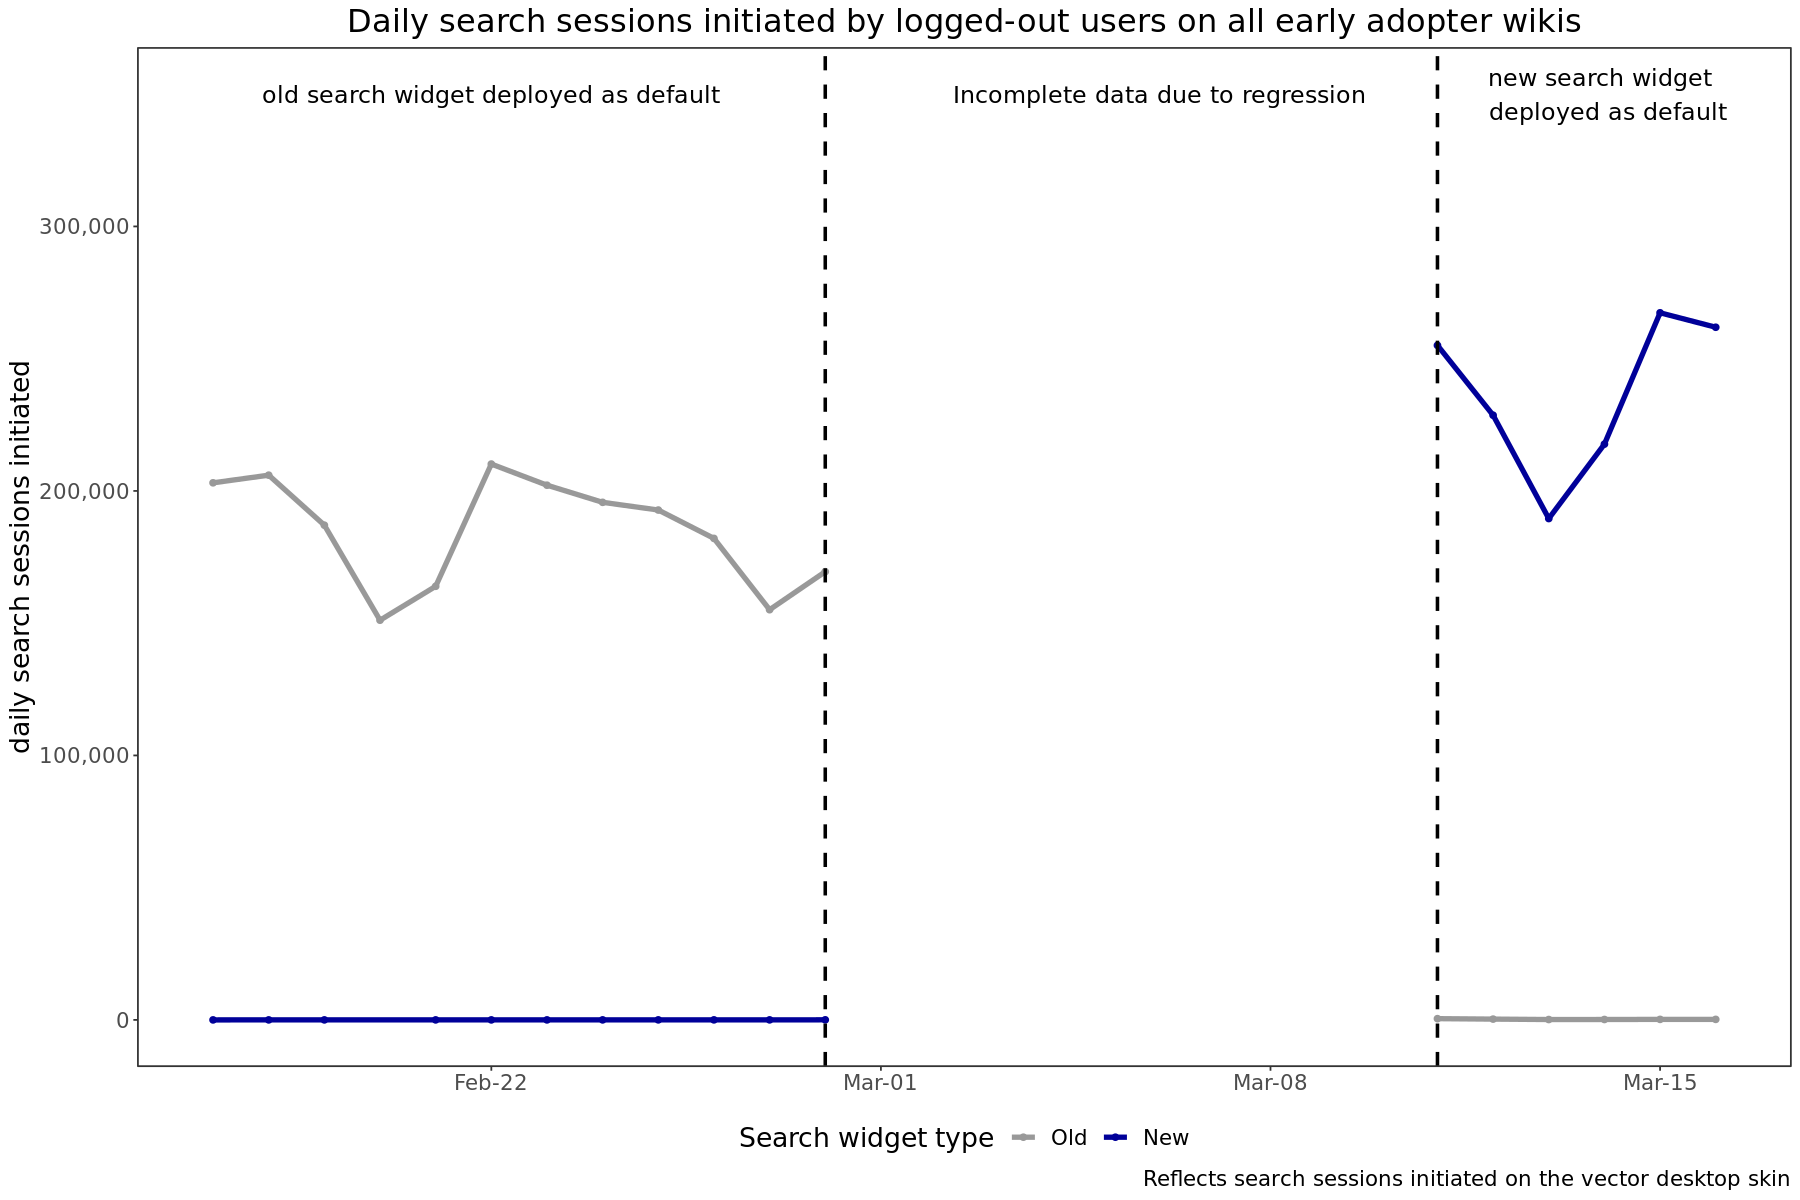

In [304]:
textaes <- data.frame(y = c(350000,350000,350000),
                      x = as.Date(c('2021-02-22','2021-03-06','2021-03-14')),
                      lab = c("old search widget deployed as default","Incomplete data due to regression", "new search widget \n deployed as default"))


p <- search_sessions_initiated_anon_daily  %>%
    group_by(session_start_date, search_type)  %>%
    summarise(num_sessions = sum(num_sessions), .groups = 'drop') %>%
    ggplot( aes(x = session_start_date, y = num_sessions, color = search_type)) +
    geom_line(size = 1.5) +
    geom_point() +
    geom_vline(xintercept = as.Date('2021-02-28'), linetype = 'dashed', size = 1) +
    geom_vline(xintercept = as.Date('2021-03-11'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
    scale_y_continuous(labels = scales::comma) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
      labs (y = "daily search sessions initiated",
              x = NULL,
             title = "Daily search sessions initiated by logged-out users on all early adopter wikis",
             caption = "Reflects search sessions initiated on the vector desktop skin")  +
     theme_bw() +
        scale_color_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old", "New"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")
      

p

In [113]:
# add column classifying pre and post deployment dates
search_sessions_initiated_anon_prepost <- search_sessions_initiated_anon_daily %>%
    mutate(deployment = case_when(
        session_start_date >= '2021-02-18' & session_start_date <= '2021-02-24' ~ 'pre',
        session_start_date >= '2021-03-11' & session_start_date <= '2021-03-17' ~ 'post',
        TRUE ~ 'NA'
    ))   %>%
    group_by(wiki, deployment) %>%
    summarize(num_sessions = sum(num_sessions), .groups = 'drop')  


In [114]:
# convert pre and post dates to factor level
search_sessions_initiated_anon_prepost$deployment <- 
    factor(search_sessions_initiated_anon_prepost$deployment,
             levels = c('NA', 'pre', 'post'),
             labels = c('NA', 'pre_deployment', 'post_deployment'))



In [115]:
# calculate post and pre changes overall

search_sessions_initiated_anon_prepost_overall <- search_sessions_initiated_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        group_by(deployment) %>%
        summarize(num_sessions =sum(num_sessions), .groups = 'keep') %>%
        spread(deployment, num_sessions) %>%
        mutate(pct_change = round((post_deployment - pre_deployment)/pre_deployment * 100, 2))
      
search_sessions_initiated_anon_prepost_overall

pre_deployment,post_deployment,pct_change
<int>,<int>,<dbl>
1316151,1421637,8.01


Comparing the total search sessions initiated a week prior to deployment and week after, we observed an 8% increase in search sessions initiated by logged-out users following deployment of the new search widget. 

Note that since a controlled experiment was not conducted on logged-out users, we are unable to conclude that this observed increase was due to the new search widget.

### Early Adopter Wiki

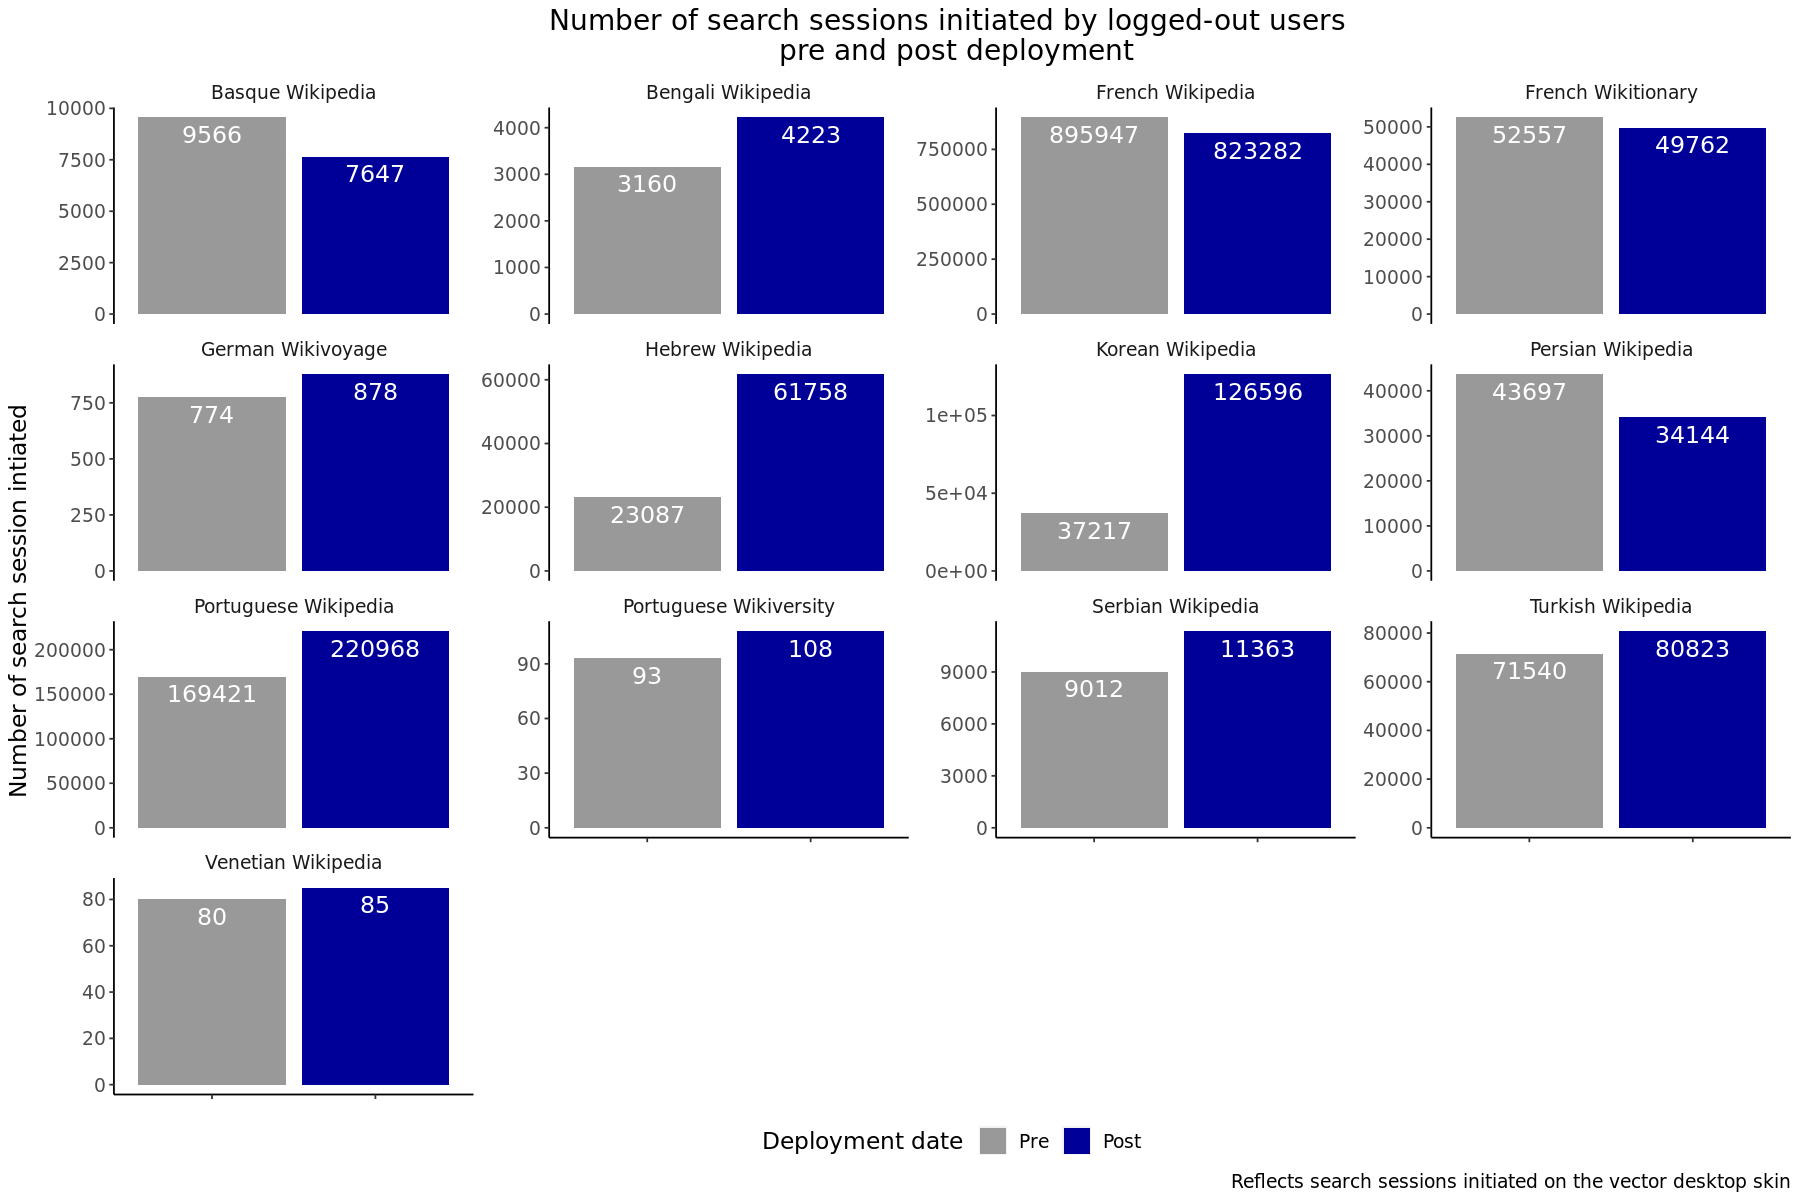

In [116]:
# plot post and pre changes

p <- search_sessions_initiated_anon_prepost %>%
        filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
        ggplot(aes(x = deployment, y= num_sessions, fill = deployment)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Search widget type",
              y = "Number of search session intiated",
             title = "Number of search sessions initiated by logged-out users \n pre and post deployment",
             caption = "Reflects search sessions initiated on the vector desktop skin")  +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment date", labels = c("Pre", "Post"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

In [117]:
# determine percent change
search_sessions_initiated_anon_prepost_pct <- search_sessions_initiated_anon_prepost %>%
    filter(deployment != 'NA') %>%  #remove dates not applicable to pre and post analysis
    spread(deployment, num_sessions) %>%
    mutate(pct_change = round((post_deployment - pre_deployment)/pre_deployment * 100, 2))



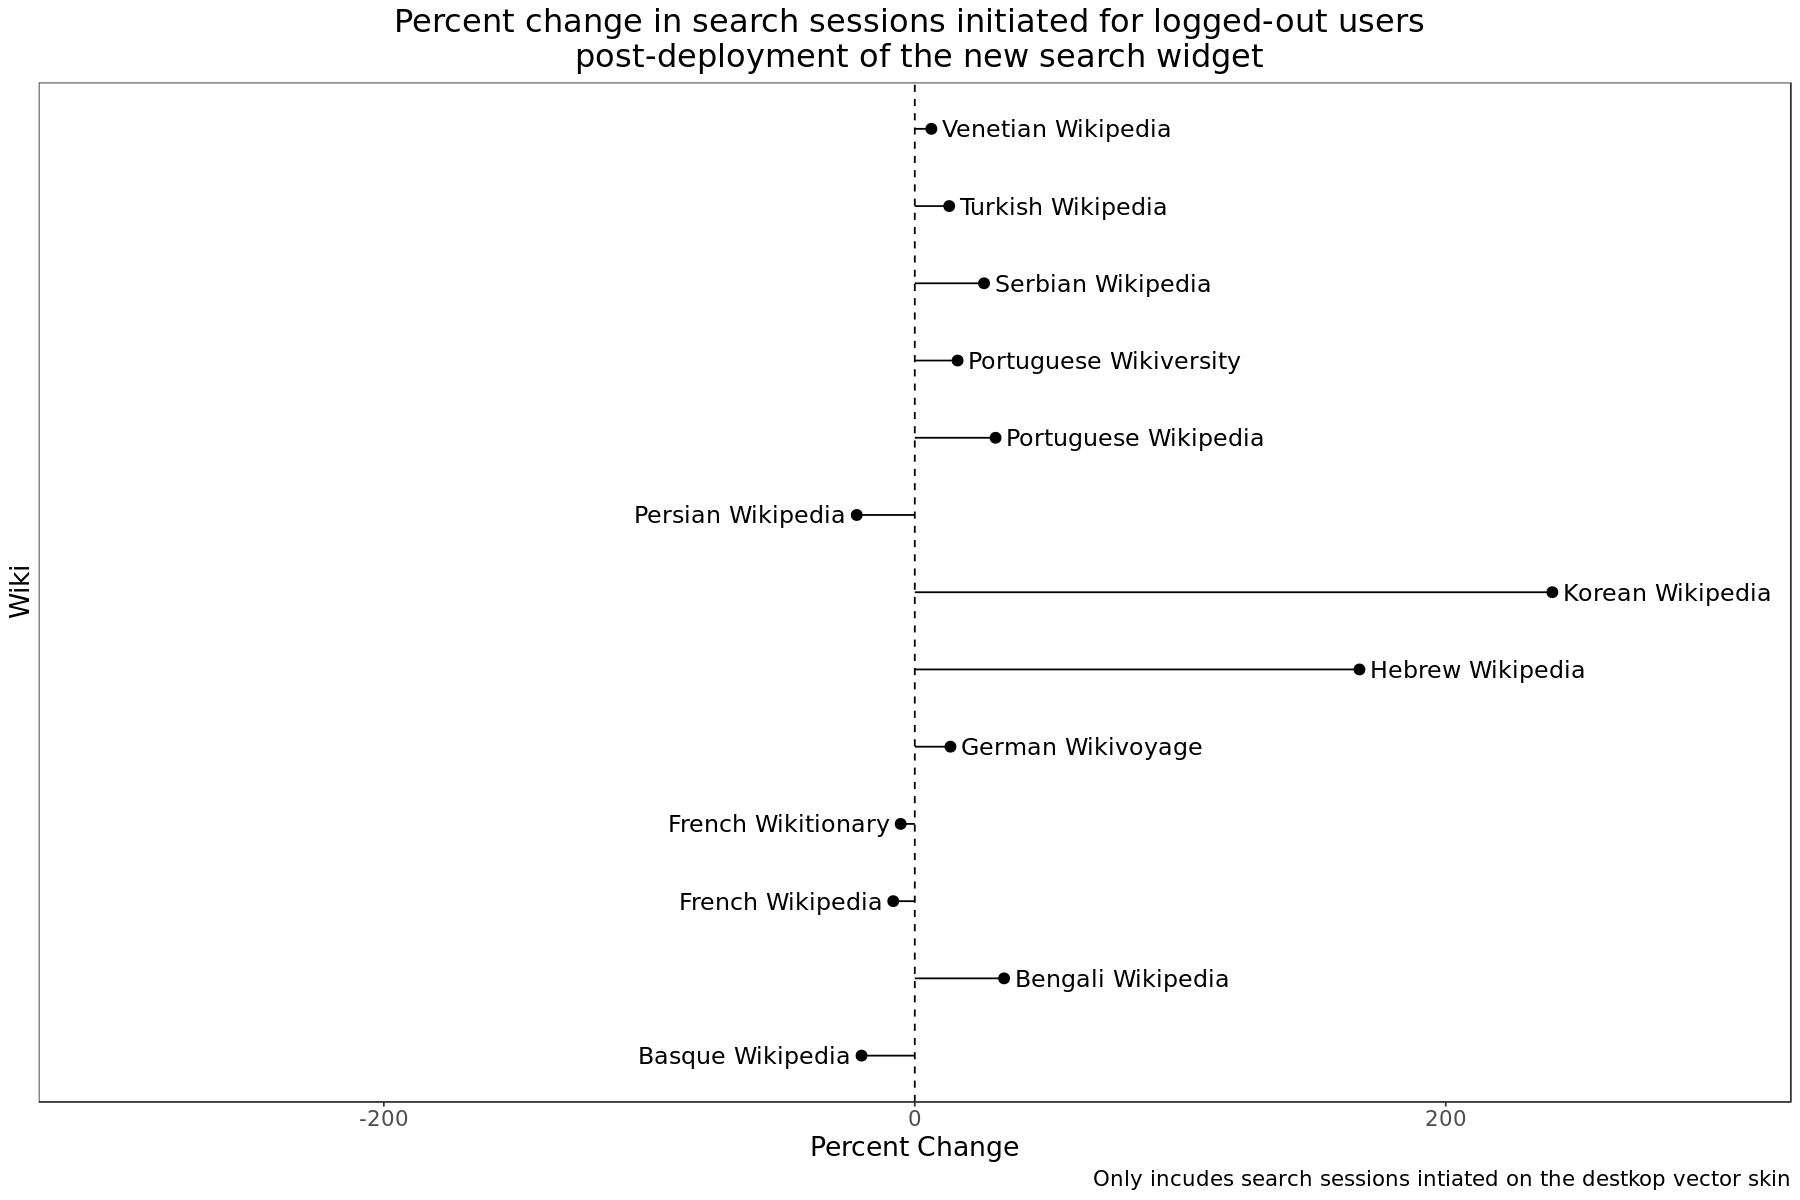

In [305]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

p <- search_sessions_initiated_anon_prepost_pct %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in search sessions initiated for logged-out users \n post-deployment of the new search widget",
             caption = "Only incudes search sessions intiated on the destkop vector skin")  +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
p




There was an average 37.8% increase[^3] in search sessions initiated by logged-out users on the early adopter wikis following deployment of the new search widget, however, this average is driven upwards due to the the high increases that occured on Hebrew (167.5% increase) and Korean Wikipedia (240.2% increase).
Looking at the median instead, there was a 13.4% increase in search sessions initiated by logged-out users on the early adopter wikis in the test.

Some key observations:
* Search sessions initiated by logged-out users more than doubled on Hebrew (167.5% increase) and tripled on Korean Wikipedia (240.2% increase). Hebrew Wikipedia had a similar percent increase for logged-in users in the AB test; however, Korean Wikipedia only saw a 31% increase for logged-in users using the new search widget. Further investigation may be needed to identify possible reasons for this sharp increase in the search sessions initiated for logged-out users on Hebrew Wikipedia. 
* We saw decreases for logged-out users on 4 out of 13 wikis reviewed. Only 1 of these Wikis (French Wikipedia) also saw a decrease in search sessions initiated by logged-in users on the AB test.
* The largest decreases in search sessions initiated by logged out users were seen on Basque Wikipedia (-20.1%) and Persian Wikipedia (-21.86%). 
* Besides the outliers of Hebrew and Korean Wikipedia, percent increases ranged from 6% to 33% on other early adopter wikis where we observed an increase in search sessions initiated post deployment. 

[^3]: Calculated by taking the average of the percent changes observed on each early adopter wiki.


# Other Interesting Search Trends

## Position of clicked result in completed searches by widget type

When a user clicks a result, we record the position of the clicked result in the search-rendered result list. For search sessions completed in the AB test, we reviewed the most frequent positions of each clicked result for each search widget type.

Note a click position of 0 is the first search-rendered result and a click position of 10 is the last result in the search-rendered result list, which is the "search for pages containing" link that takes the user to Special:Search page.

In [241]:
# find sessions that were completed and included a clict to an autocomplete search
search_sessions_completed_ab_resultclick <- search_sessions_completed_ab %>%   
    mutate(clicked_through = ifelse((clicked_through == 1 & position >= 0 & position < 11), 1, 0))

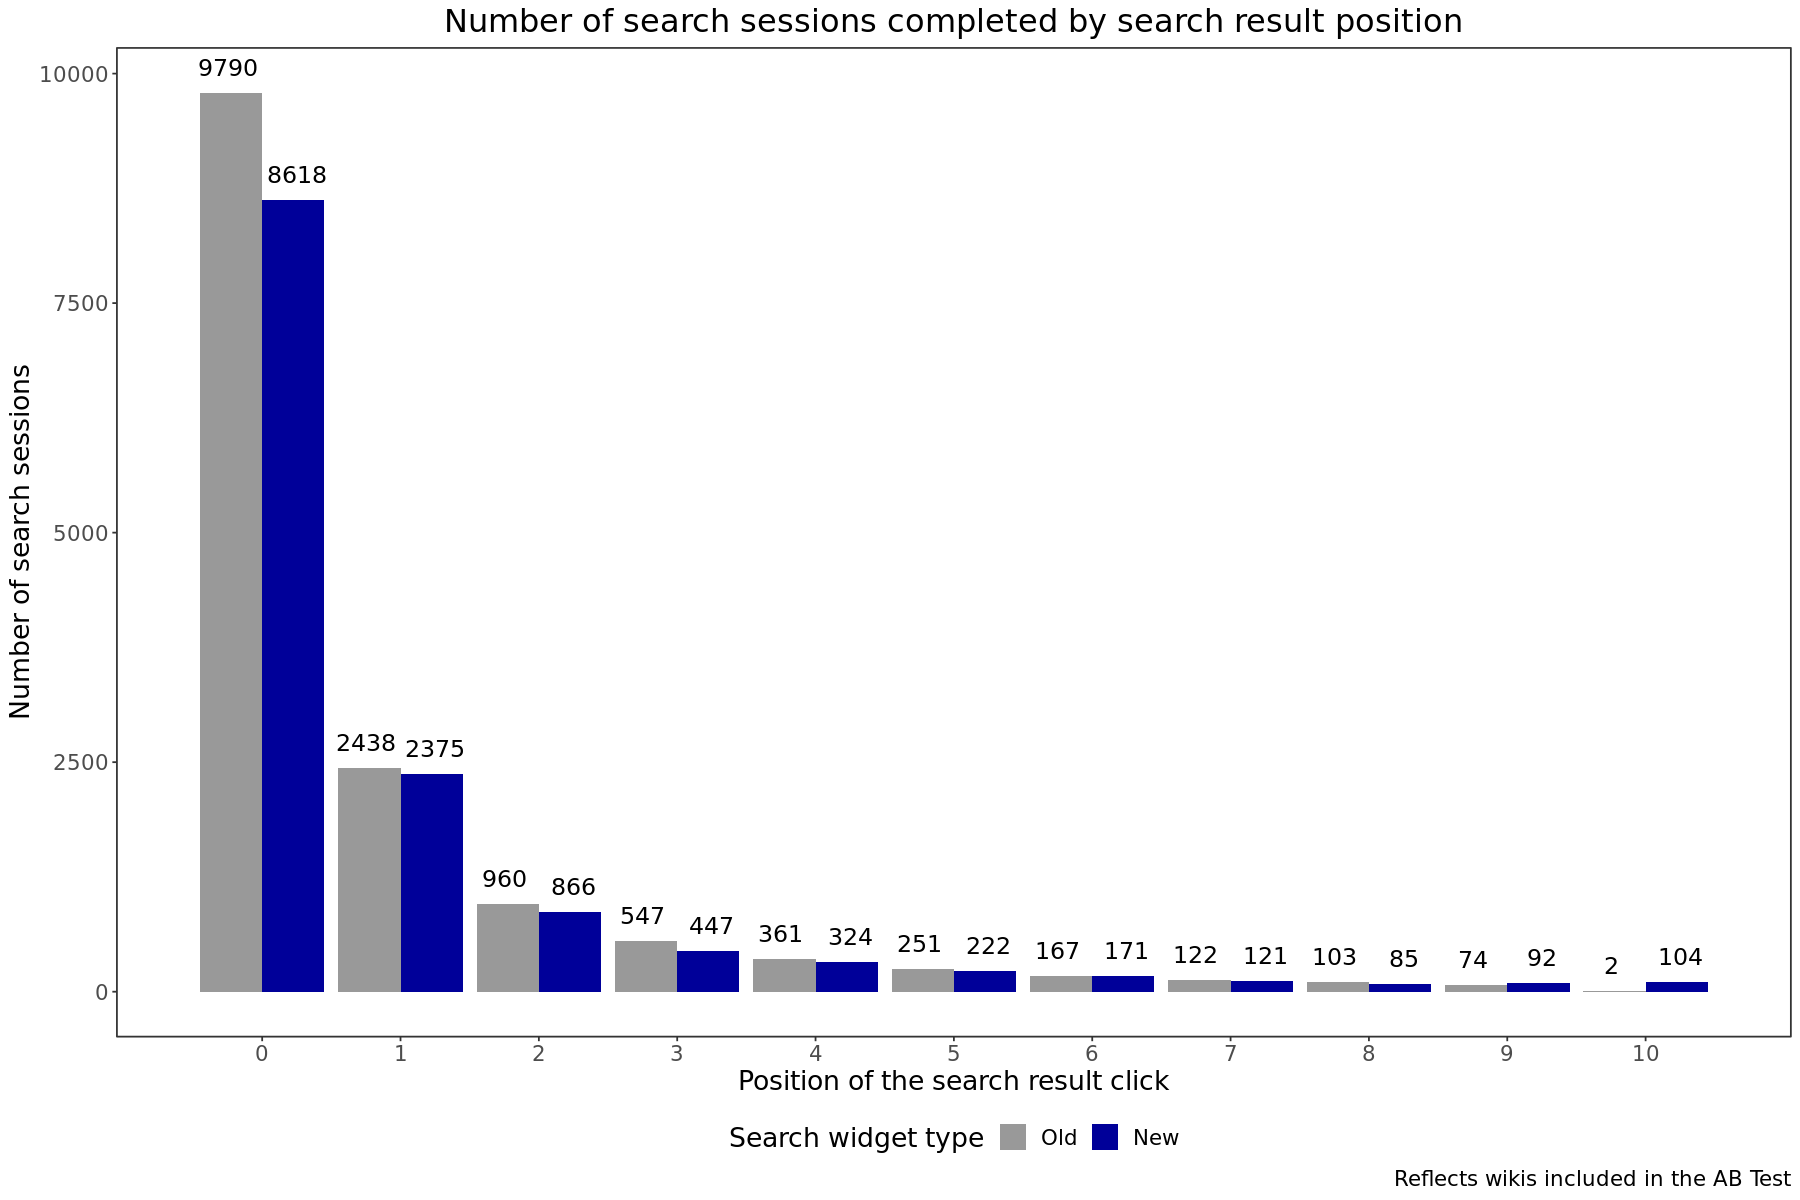

In [244]:
# Plot overall clicks by postion

p <- search_sessions_completed_ab_resultclick %>%
    filter(clicked_through == 1)  %>% # only successful searches
    group_by(position, search_type)  %>%
    summarize(num_sessions = n_distinct(search_session), .groups = 'drop') %>%
    ggplot(aes(x= position, y = num_sessions, fill = search_type)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(num_sessions)), position = position_dodge(width = 1), color = "black", vjust=-1, size = 5) +
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +
    labs (y = "Number of search sessions",
              x ="Position of the search result click",
             title = "Number of search sessions completed by search result position",
             caption = "Reflects wikis included in the AB Test")  +
        theme_bw() +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Search widget type", labels = c("Old", "New"))  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "bottom")
    
  
p
    

Users shown the old search widget in the AB test selected the first result in the search-rendered result list more frequently than users shown the new search widget. 

Interestingly, there were significantly more sessions that included a click the 10th result ("the search pages containining" result) in the search-rendered result set when shown the new search widget. We further reviewed clicks to the 10th result by early adopter wiki.

### Sessions with clicks to 'Search for pages containing' by early adopter wiki

In [262]:
position_10_clicks_bywiki <- search_sessions_completed_ab_resultclick %>%
    filter(clicked_through == 1,
          position == 10)  %>% # only successful searches with clicks to the 10th result
    group_by(wiki, search_type)  %>%
    summarize(num_sessions = n_distinct(search_session), .groups = 'drop') %>%
    mutate(num_sessions = replace(num_sessions, num_sessions == 'NA', 0)) %>%
    pivot_wider(names_from = search_type, values_from = num_sessions, values_fill=0) %>%
    gt() %>%
    tab_header("Number of sessions in AB test with clicks to \'search for pages containing result\'") %>%
    cols_label(wiki = "Wiki project",
               new_search_widget = "New search widget",
               old_search_widget = "Old search widget") %>%
      gtsave(
    "tenth_position_click.html", inline_css = TRUE)


IRdisplay::display_html(data = position_10_clicks_bywiki, file = "tenth_position_click.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 Number of sessions in AB test with clicks to 'search for pages containing result' 
 
 
 
 
 
 
 
 Wiki project 
 New search widget 
 Old search widget 
 
 
 
 
 Basque Wikipedia 
 2 
 0 
 
 
 French Wikipedia 
 49 
 0 
 
 
 French Wikitionary 
 1 
 1 
 
 
 Hebrew Wikipedia 
 6 
 0 
 
 
 Korean Wikipedia 
 2 
 0 
 
 
 Persian Wikipedia 
 16 
 0 
 
 
 Portuguese Wikipedia 
 13 
 1 
 
 
 Serbian Wikipedia 
 8 
 0 
 
 
 Turkish Wikipedia 
 7 
 0

There were only 2 search sessions to the "search for pages containing" result by users shown the old search widget. On the new search widget, there were 104 search sessions with clicks to this result across 9 different early adopter wikis. 

Further investigation is needed to determine if this is indicative a change in user behavior due to the new design or potential instrumentation issue resulting in more logged clicks to the 10th result for the new search widget. 